Following [this tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
sns.set_context('notebook')
%matplotlib inline

## Regression

### Data generation

In [105]:
np.random.seed(42)
X = np.random.rand(100,1)
Y = 1 + 2*X + .1*np.random.randn(100,1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2) 

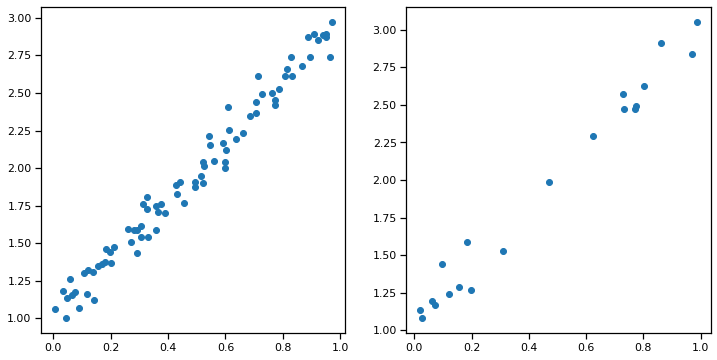

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x_train, y_train, 'o')
plt.subplot(1,2,2)
plt.plot(x_test, y_test, 'o')

## Fit Model

First we will do this without an optimizer

In [20]:
# a/b
params = torch.randn(2, requires_grad=True, dtype=torch.float, device=device)

nepochs = 1000
lr = .1
loss_fun = torch.nn.MSELoss()
for epoch in range(nepochs):
    x = torch.from_numpy(x_train).to(device)
    y = torch.from_numpy(y_train).to(device)
    yhat = params[0]+params[1]*x
    loss = loss_fun(yhat, y)
    
    # compute gradient
    
    loss.backward()
    # update parameters
    with torch.no_grad():
        params -= lr*params.grad
    params.grad.zero_()

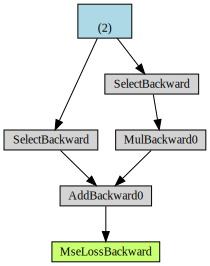

In [27]:
# visualize the graph for the loss
make_dot(loss)

Now with an optimizer

In [37]:
# a/b
params = torch.randn(2, requires_grad=True, dtype=torch.float, device=device)

nepochs = 1000
optimizer = torch.optim.SGD([params], lr=1e-1)
loss_fun = torch.nn.MSELoss()
for epoch in range(nepochs):
    x = torch.from_numpy(x_train).to(device)
    y = torch.from_numpy(y_train).to(device)
    yhat = params[0]+params[1]*x
    loss = loss_fun(yhat, y)
    
    # compute gradient
    loss.backward()
    
    # update parameters
    optimizer.step()
    optimizer.zero_grad()

Now let's define a model class

In [48]:
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.params = torch.nn.Parameter(
                            torch.randn(2, requires_grad=True, 
                            dtype=torch.float, device=device)
                        )
        
    def forward(self, x):
        return self.params[0]+self.params[1]*x


In [56]:
# a/b
nepochs = 1000
model = LinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_fun = torch.nn.MSELoss()
for epoch in range(nepochs):
    x = torch.from_numpy(x_train).to(device)
    y = torch.from_numpy(y_train).to(device)
    model.train() # this is not needed for us now, but is sometimes needed, i.e., dropout
    yhat = model(x)
    
    # compute gradient
    loss = loss_fun(yhat, y)
    loss.backward()
    
    # update parameters
    optimizer.step()
    optimizer.zero_grad()

In [59]:
class SimplerLinearRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.params = nn.Linear(1,1)
        
    def forward(self, x):
        return self.params(x)


In [67]:
# a/b
nepochs = 1000
model = SimplerLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_fun = torch.nn.MSELoss()
for epoch in range(nepochs):
    x = torch.from_numpy(x_train).float().to(device)
    y = torch.from_numpy(y_train).float().to(device)
    model.train() # this is not needed for us now, but is sometimes needed, i.e., dropout
    yhat = model(x)
    
    # compute gradient
    loss = loss_fun(yhat, y)
    loss.backward()
    
    # update parameters
    optimizer.step()
    optimizer.zero_grad()

## Helpful to abstract training into another function

In [71]:

def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [76]:
model = SimplerLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_fun = torch.nn.MSELoss()
train_step = make_train_step(model, loss_fun, optimizer)

nepochs = 1000
for epoch in range(nepochs):
    x = torch.from_numpy(x_train).float().to(device)
    y = torch.from_numpy(y_train).float().to(device)
    train_step(x,y)

## Let's make a dataset class

Creating a custom dataset allows us to make use of dataloaders

In [78]:
from torch.utils.data import Dataset, TensorDataset

In [79]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    
    def __len(self):
        return len(self.x)

In [85]:
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# our custom class, which just replaces the function of TensorDataset for two tensors
train_data = CustomDataset(x_train_tensor, y_train_tensor)

# simpler way to do this
train_data = TensorDataset(x_train_tensor, y_train_tensor) # have as many tensors as we want

In [90]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

Train with data loader

In [91]:
model = SimplerLinearRegression()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_fun = torch.nn.MSELoss()


losses = []
nepochs=1000
train_step = make_train_step(model, loss_fun, optimizer)

for epoch in range(nepochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        loss = train_step(x_batch, y_batch)
        losses.append(loss)

There are other ways to split the data. Before we split the dataset when they were numpy arrays, created separate datasets and then created separate dataloaders (well, we actually only created the train dataloader, but validation would be the same).

We can use `random_split` instead to split a dataset. This allows us to...

## Evaluate

In [111]:
from torch.utils.data.dataset import random_split

dataset = TensorDataset(torch.from_numpy(X).float(),
                        torch.from_numpy(Y).float())
train_len = int(len(dataset)*.8)
val_len = int(len(dataset)*.1)
test_len = len(dataset) - train_len - val_len
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_len,
                                                                        val_len,
                                                                        test_len])

In [117]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=validation_dataset, batch_size=20)
test_loader = DataLoader(dataset=test_dataset, batch_size=20)

In [135]:
losses = []
val_losses = []
nepochs=1000

model = nn.Sequential(nn.Linear(1,1))
loss_fun = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1E-1)
train_step = make_train_step(model, loss_fun, optimizer)
for epoch in range(nepochs):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        yhat = model(inputs)
        loss = train_step(inputs, outputs)
        losses.append(loss)
        
    with torch.no_grad():
        model.eval()
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            val_losses.append(loss_fun(model(x_val), y_val).item())